In [46]:
import os               # Allows interaction with this program and the OS
import cv2            # OpenCV is computer vision software written in C and cv2 lets python read it through "bindings"
import numpy as np  
import matplotlib as plt
from tqdm import tqdm   # Lets you put a progress bar next to your loops

REBUILD_DATA = True         # This is to signal that preprocessing has been done

class DogsVSCats():
    IMG_SIZE = 50               # factor by which we shrink everything to 50 by 50 pixels. Only one of many different ways to augment your training set (possible to transform them in different ways and multiply their training size)
    CATS = "PetImages\Cat"      # Specify directories to find cat and dog pictures
    DOGS = "PetImages\Dog"
    LABELS = {CATS: 0, DOGS: 1}     # One hot encoding -> 
    training_data = []
    catcount = 0            # To BALANCE datset
    dogcount = 0

    def make_training_data(self):
        for label in self.LABELS:       # Iterates through the keys of the dictionaries (Which are filepaths for our data)
            for f in tqdm(os.listdir(label)):           # os.listdir(label) asks for the directory listing of filenames for all files within the folder. f then iterates through them and we join it to the rest of the file path below
                try:
                    path = os.path.join(label,f)            # creates address for individual files
                    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)            # cv2 reads the picture file as a greyscale () adding color doesn't really add in a dimension but adds channels, making it greyscale means we worry about handling less data
                    img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))           # does the shrinking part
                    self.training_data.append([np.array(img), np.eye(2)[self.LABELS[label]]])       # eye(2)[1] = [0,1] so self.LABELS is our dictonary of cat/dog index positions and it'll give the POSITION of where to add the one

                    if label == self.CATS:
                        self.catcount += 1
                    elif label == self.DOGS:
                        self.dogcount += 1
                except Exception as e:
                    pass

        np.random.shuffle(self.training_data)           # Shuffle data in place
        np.save("training_data.npy", self.training_data)        # save the file under that filename
        print("Cats:", self.catcount)               # Print out the composition
        print("Dogs:", self.dogcount) 

if REBUILD_DATA:
    dogsvcats = DogsVSCats()
    dogsvcats.make_training_data()


114.01it/s]
100%|██████████| 12501/12501 [01:53<00:00, 110.20it/s]
Cats: 12476
Dogs: 12470


In [135]:
training_data = np.load("training_data.npy", allow_pickle = True)           # Allows us to load the pickled data
print(training_data[100][1])

[1. 0.]


50


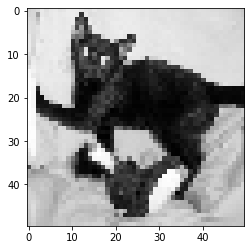

In [136]:
from matplotlib import pyplot as plt

print(len(training_data[100][0]))

plt.imshow(training_data[100][0], cmap = 'gray')
plt.show()

In [137]:
print(training_data[0])     # This shows that the 0th element of data is the grid of values and also the key(cat or dog)
Test = training_data[0].shape[0] # Makes sense that the size of the zeroth data has an array of values + key (2)
print("training_data[0].shape[0]:",Test)
# Test = training_data[0].shape[1]
# print("training_data[0].shape[1]:",Test)

# test2 = training_data[0].shape[0] * training_data[0].shape[1]

[array([[ 74, 101,  90, ..., 101, 138, 111],
       [ 73,  65,  68, ..., 107, 114, 139],
       [ 95,  98,  78, ..., 109, 101, 113],
       ...,
       [112,  85,  98, ...,  87, 104,  93],
       [ 88,  96, 108, ...,  68, 100,  65],
       [ 90, 124,  92, ..., 105, 118,  95]], dtype=uint8)
 array([0., 1.])]
training_data[0].shape[0]: 2


In [138]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 5)            # Takes in one input, outputs 32 convelutional channels for a different kernel that it's read. Has a "kernel" or looking space of 5x5. Conv2d handles 2d data
        self.conv2 = nn.Conv2d(32, 64, 5) 
        self.conv3 = nn.Conv2d(64, 128, 5)

        self.fc1 = nn.Linear(128 * 2 * 2, 512)
        self.fc2 = nn.Linear(512, 2)

    def forward(self, t):
        # (1) input layer
        t = t

        # (2) hidden conv layer
        t = self.conv1(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size = 2, stride = 2)

        # (3) hidden conv layer
        t = self.conv2(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size = 2, stride = 2)

        # (4) hidden conv layer
        t = self.conv3(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size = 2, stride = 2)

        # (5) hidden linear layer
        t = t.reshape(-1, 128 * 2 * 2)
        t = self.fc1(t)
        t = F.relu(t)
            # Alternative writing (that actually applies to any of the above): t = F.relu(self.fc1(t))

        # (6) last linear layer
        t = self.fc2(t)
        # F.softmax(t, dim = 1)  # Here we'll train with cross entropy so we won't use softmax here

        return F.softmax(t, dim = 1)

In [151]:
net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=512, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
)


In [152]:
# torch.set_grad_enabled(False)

In [153]:
import torch.optim as optim

optimizer = optim.Adam(net.parameters(), lr = 0.001)
loss_function = nn.MSELoss()

In [154]:
len(training_data)

24946

In [155]:
X = torch.Tensor([i[0] for i in training_data]).view(-1,50,50) #Assembles a tensor of 50x50 individual elements that comprise the entire dataset
X = X/255.0     # Normalize the data
y = torch.Tensor([i[1] for i in training_data])     # y greps all the labels



In [156]:
val_PCT = 0.1
val_size = int(len(X) * val_PCT)        # Seperating out training set from testing set
print(val_size)

2494


In [157]:
train_X = X[:-val_size]        
train_y = y[:-val_size]

test_X = X[-val_size:]
test_y = y[-val_size:]

print(len(train_X))
print(len(test_X))

22452
2494


In [172]:
BATCH_SIZE = 100
EPOCHS = 5
net.train()

for epoch in range(EPOCHS):
    for i in tqdm(range(0, len(train_X), BATCH_SIZE)):
        # print(i, i+BATCH_SIZE)
        batch_X = train_X[i:i+BATCH_SIZE].view(-1,1,50,50)
        batch_y = train_y[i:i+BATCH_SIZE]

        net.zero_grad()
        # you can also run optimizer.zero_grad which will zero out the optimizer for all models
        outputs = net(batch_X)
        loss = loss_function(outputs, batch_y)
        loss.backward()
        optimizer.step()

    # print(f"Epoch: {epoch}. Loss: {loss}")


█████▊  | 176/225 [04:44<01:20,  1.64s/it]





 79%|███████▊  | 177/225 [04:46<01:20,  1.68s/it]





 79%|███████▉  | 178/225 [04:47<01:16,  1.62s/it]





 80%|███████▉  | 179/225 [04:49<01:13,  1.60s/it]





 80%|████████  | 180/225 [04:50<01:11,  1.59s/it]





 80%|████████  | 181/225 [04:52<01:08,  1.56s/it]





 81%|████████  | 182/225 [04:53<01:07,  1.57s/it]





 81%|████████▏ | 183/225 [04:55<01:05,  1.55s/it]





 82%|████████▏ | 184/225 [04:56<01:04,  1.56s/it]





 82%|████████▏ | 185/225 [04:58<01:03,  1.60s/it]





 83%|████████▎ | 186/225 [05:00<01:04,  1.66s/it]





 83%|████████▎ | 187/225 [05:01<01:01,  1.63s/it]





 84%|████████▎ | 188/225 [05:03<00:59,  1.61s/it]





 84%|████████▍ | 189/225 [05:05<01:02,  1.73s/it]





 84%|████████▍ | 190/225 [05:06<00:57,  1.65s/it]





 85%|████████▍ | 191/225 [05:08<00:54,  1.61s/it]





 85%|████████▌ | 192/225 [05:09<00:52,  1.58s/it]





 86%|████████▌ | 193/225 [05:11<00:51,  1.60s/it]





 86%|████████▌ | 

In [182]:
correct = 0
total = 0
net.eval()
with torch.no_grad():
    for i in tqdm(range(len(outputs))):
        real_class = torch.argmax(test_y[i])     # Argmax returns the index of the largest value
        net_out = net(test_X[i].view(-1,1,50,50))[0]        #Returns a list of predictions for the test
        predicted_class = torch.argmax(net_out)

        if predicted_class == real_class:
            correct += 1
        total += 1








  0%|          | 0/52 [00:00<?, ?it/s]





 35%|███▍      | 18/52 [00:00<00:00, 173.73it/s]





100%|██████████| 52/52 [00:00<00:00, 183.76it/s]


In [183]:

print("Accuracy:", round(correct/total,3))


Accuracy: 0.769


In [186]:
print(torch.argmax(outputs[0]))
print(test_y[0])
print(test_x.shape)
print(test_x[0])

tensor(1, grad_fn=<NotImplemented>)
tensor([1., 0.])
torch.Size([2494, 50, 50])
tensor([[0.3608, 0.4902, 0.5216,  ..., 0.5412, 0.5098, 0.5020],
        [0.4627, 0.4941, 0.5373,  ..., 0.5255, 0.5059, 0.4863],
        [0.5020, 0.5294, 0.5333,  ..., 0.5373, 0.4275, 0.5020],
        ...,
        [0.6039, 0.7961, 0.7922,  ..., 0.6314, 0.6118, 0.6784],
        [0.5255, 0.7804, 0.7569,  ..., 0.6706, 0.6706, 0.6941],
        [0.5490, 0.7765, 0.7608,  ..., 0.6667, 0.6706, 0.7333]])


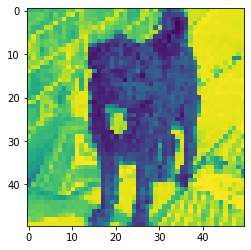

tensor(1, grad_fn=<NotImplemented>)


In [202]:
plt.imshow(test_x[25].reshape(50,50))
plt.show()
print(torch.argmax(outputs[25]))